# Global Connectivity Preference

In [1]:
fmri_data_label = None
dwi_data_label = None
roi_subset = None
results_dir = None
resource_dir = None

In [2]:
# Parameters
dwi_data_label = "Yeh-HCP842"
results_dir = "/home/despo/dlurie/Projects/timescale_hierarchy/results"
resource_dir = "/home/despoB/dlurie/Projects/timescale_hierarchy/data/resources"
fmri_data_label = "NKI-1400_HY_CompCor"
roi_subset = "CX"


In [3]:
import sys
import os
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.spatial import distance
from stat import S_IREAD, S_IRGRP, S_IROTH

In [4]:
sys.path.append('/home/despo/dlurie/Projects/timescale_hierarchy/code/scripts')
sys.path.append('/home/despo/dlurie/Projects/PyPALM/')

In [5]:
import affinity_preference as ap
import pypalm as pm
import utils

In [6]:
%config InlineBackend.figure_format = 'retina'
sns.set_context('talk')

In [7]:
# Load data for analysis
gamma_range = np.arange(5,36,1) / 10

fc_pc_df, fc_wd_df = utils.load_cartography(f'{results_dir}/functional_connectivity/{fmri_data_label}_BNA_zmat_mean_po_Cartography/', 'MegaPart')
sc_pc_df, sc_wd_df = utils.load_cartography(f'{results_dir}/structural_connectivity/{dwi_data_label}_BNA_log_count_mat_Louvain')

sc_degree_df = pd.read_csv(f'{results_dir}/structural_connectivity/{dwi_data_label}_BNA_degree_df.tsv', delimiter='\t', index_col=0)
fc_degree_df = pd.read_csv(f'{results_dir}/functional_connectivity/{fmri_data_label}_BNA_degree_df.tsv', delimiter='\t', index_col=0)

ts_df = pd.read_csv(f'{results_dir}/timescales/{fmri_data_label}_BNA_timescale_df.csv')
roi_vols = np.genfromtxt(f'{resource_dir}/BNA-maxprob-thr25-2mm_ROI_volumes.txt')

# Load the list of replicated effects
re_df = pd.read_csv(f'{results_dir}/stats/timescale_associations/TA_Replicated_Effects_{roi_subset}.csv')
re_df.columns = ['measure', 'rep_status']
re_df.measure = [i.replace('.','_') for i in re_df.measure]
re_cols = list(re_df[re_df.rep_status=='*'].measure.values)

# Combine data into a single DataFrame
df_all = pd.concat([sc_pc_df, fc_pc_df, sc_wd_df, fc_wd_df,
                    sc_degree_df.log_count_strength, fc_degree_df.strength_zmean_po], axis=1)
if roi_subset == 'CX':
    df_all.columns = re_df.measure[:-2]
elif roi_subset == 'WB':
    df_all.columns = re_df.measure
df_all['roi_vols'] = roi_vols
df_all['lag1'] = ts_df.lag1_median.values

# Load ROI coordinates and calculate pairwise distances.
coord_list = np.loadtxt(f'{resource_dir}/BNA-maxprob-thr25-1mm_coords.txt')
from scipy.spatial import distance
ed_mat = distance.cdist(coord_list, coord_list)

# Load group-averaged FC matrix, convert from z-scores to correlations.
corr_mat_z = np.loadtxt(f'{results_dir}/functional_connectivity/{fmri_data_label}_BNA_zmat_mean_po.csv')
corr_mat_r = np.tanh(corr_mat_z)

# Load population atlas SC matrix.
sc_mat = np.genfromtxt(f'{results_dir}/structural_connectivity/{dwi_data_label}_BNA_log_count_mat.csv', delimiter=',')

if roi_subset == 'CX':
    # Slice data to include only cortical ROIs.
    df_all = df_all[:210]
    ed_mat = utils.subset_ROIs(ed_mat, division='ctx', symmetric=True)
    corr_mat_r = utils.subset_ROIs(corr_mat_r, division='ctx', symmetric=True)
    sc_mat = utils.subset_ROIs(sc_mat, division='ctx', symmetric=True)

In [8]:
# Create a data frame containing pairwise data types, sliced into 1D vectors by taking the off-diagonal elements of the upper triangle of the square matrices.
dat_edges = pd.DataFrame(np.array([corr_mat_r[np.triu_indices_from(corr_mat_r, k=1)],
                                   sc_mat[np.triu_indices_from(sc_mat, k=1)],
                                   ed_mat[np.triu_indices_from(ed_mat, k=1)]]).T,
                                   columns=['fc_edges','sc_edges','ed'])

In [9]:
# Generate inputs for the full models.
FCK_RE_vars = list(set.union(set(re_cols),set(['fc_strength','roi_vols'])))
FCK_RE_vars = ' + '.join(FCK_RE_vars)

SCK_RE_vars = list(set.union(set(re_cols),set(['sc_strength','roi_vols'])))
SCK_RE_vars = ' + '.join(SCK_RE_vars)

In [10]:
Lag1_vs_ROIv_YData = utils.get_YData('Lag1_vs_ROIv', 'roi_vols', df_all, results_dir, fmri_data_label, roi_subset)
Lag1_vs_ROIv_FCK_YData = utils.get_YData('Lag1_vs_ROIv_FCK', 'roi_vols + fc_strength', df_all, results_dir, fmri_data_label, roi_subset)
Lag1_vs_ROIv_FCK_RE_YData = utils.get_YData('Lag1_vs_ROIv_FCK_RE', FCK_RE_vars, df_all, results_dir, fmri_data_label, roi_subset)
Lag1_vs_ROIv_SCK_YData = utils.get_YData('Lag1_vs_ROIv_SCK', 'roi_vols + sc_strength', df_all, results_dir, fmri_data_label, roi_subset)
Lag1_vs_ROIv_SCK_RE_YData = utils.get_YData('Lag1_vs_ROIv_SCK_RE', SCK_RE_vars, df_all, results_dir, fmri_data_label, roi_subset)

## FC

### e(lag|roi_vols) ~ FC

In [11]:
Lag1eROIv_vs_FC = ap.null_corr(Lag1_vs_ROIv_YData.y_raw, corr_mat_r, 10000, feat_perms=Lag1_vs_ROIv_YData.y_perms,
                               dropz=False, return_null=True, return_surrogates=False)

In [12]:
Lag1eROIv_vs_FC.r_obs

,n,r,CI95%,p-val,BF10,power
pearson,21945,-0.265834,"[-0.28, -0.25]",0.0,inf,1.0


In [13]:
Lag1eROIv_vs_FC.p_vals

p_greater    0.9979
p_less       0.0022
p_abs        0.0022
dtype: float64

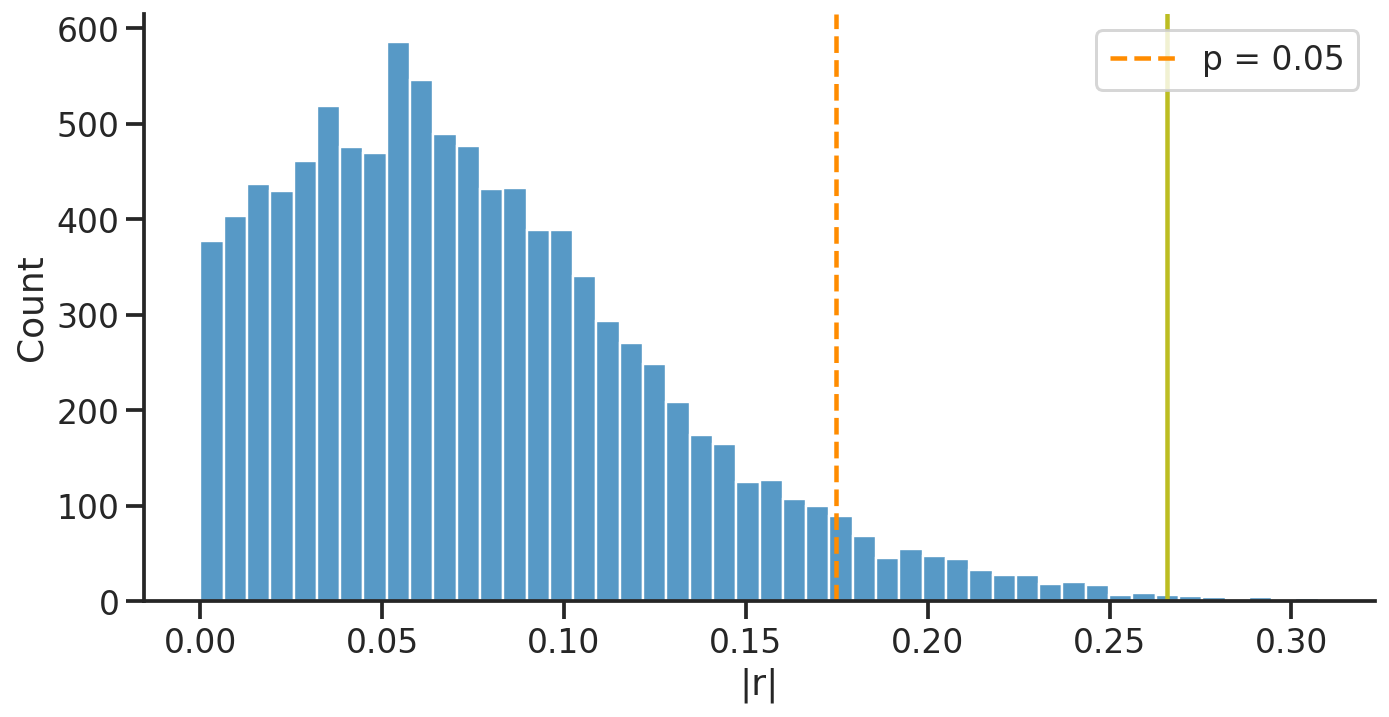

In [14]:
utils.plot_null_hist(Lag1eROIv_vs_FC.r_obs.r.pearson, Lag1eROIv_vs_FC.r_null)

### e(lag|roi_vols) ~ FC + ED

In [15]:
Lag1eROIv_vs_FC_zED = ap.manly_corr(Lag1_vs_ROIv_YData, dat_edges, 'fc_edges', 'ed')

In [16]:
Lag1eROIv_vs_FC_zED.stat_obs

array([-0.26345625])

In [17]:
Lag1eROIv_vs_FC_zED.p_vals

p_greater    1.0000
p_less       0.0001
p_abs        0.0001
dtype: float64

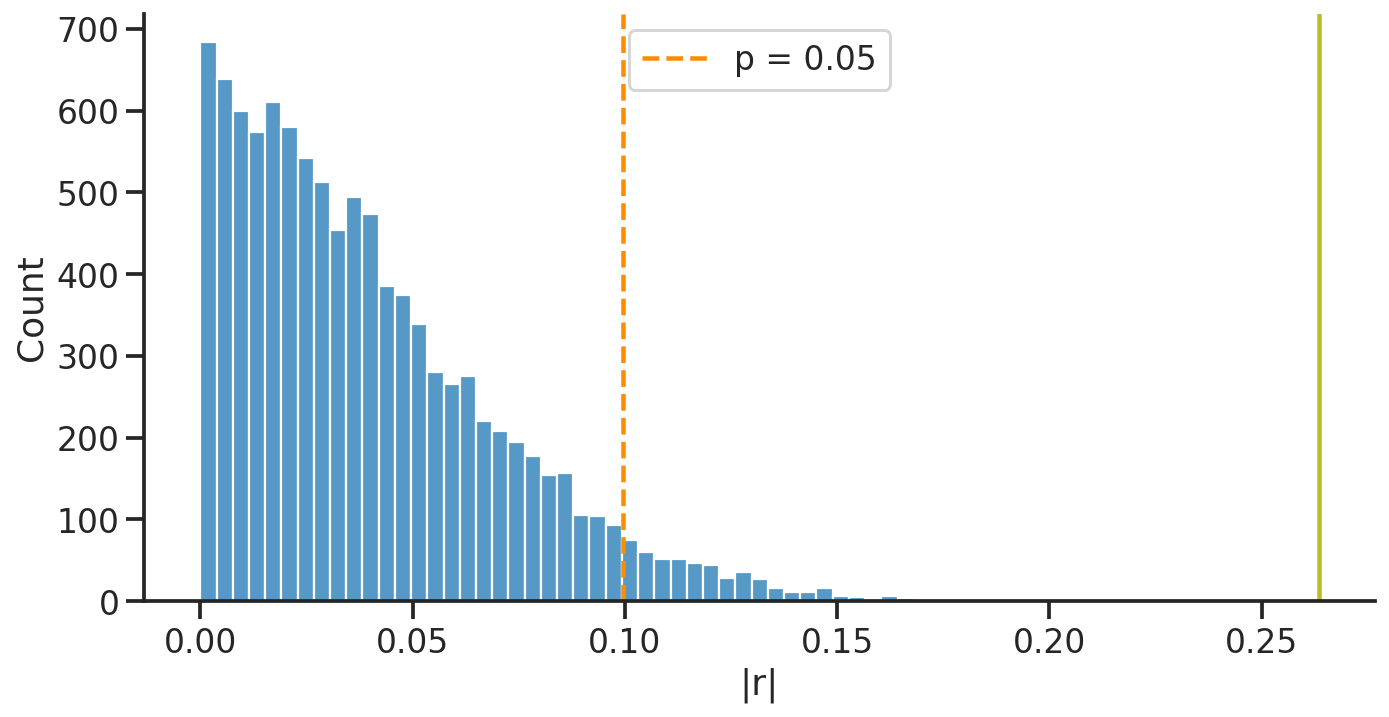

In [18]:
utils.plot_null_hist(Lag1eROIv_vs_FC_zED.stat_obs, Lag1eROIv_vs_FC_zED.stat_null)

### e(lag|roi_vols + FC K) ~ FC + ED

In [19]:
Lag1eROIv_FCK_vs_FC_zED = ap.manly_corr(Lag1_vs_ROIv_FCK_YData, dat_edges, 'fc_edges', 'ed')

In [20]:
Lag1eROIv_FCK_vs_FC_zED.stat_obs

array([-0.1987051])

In [21]:
Lag1eROIv_FCK_vs_FC_zED.p_vals

p_greater    1.0000
p_less       0.0001
p_abs        0.0001
dtype: float64

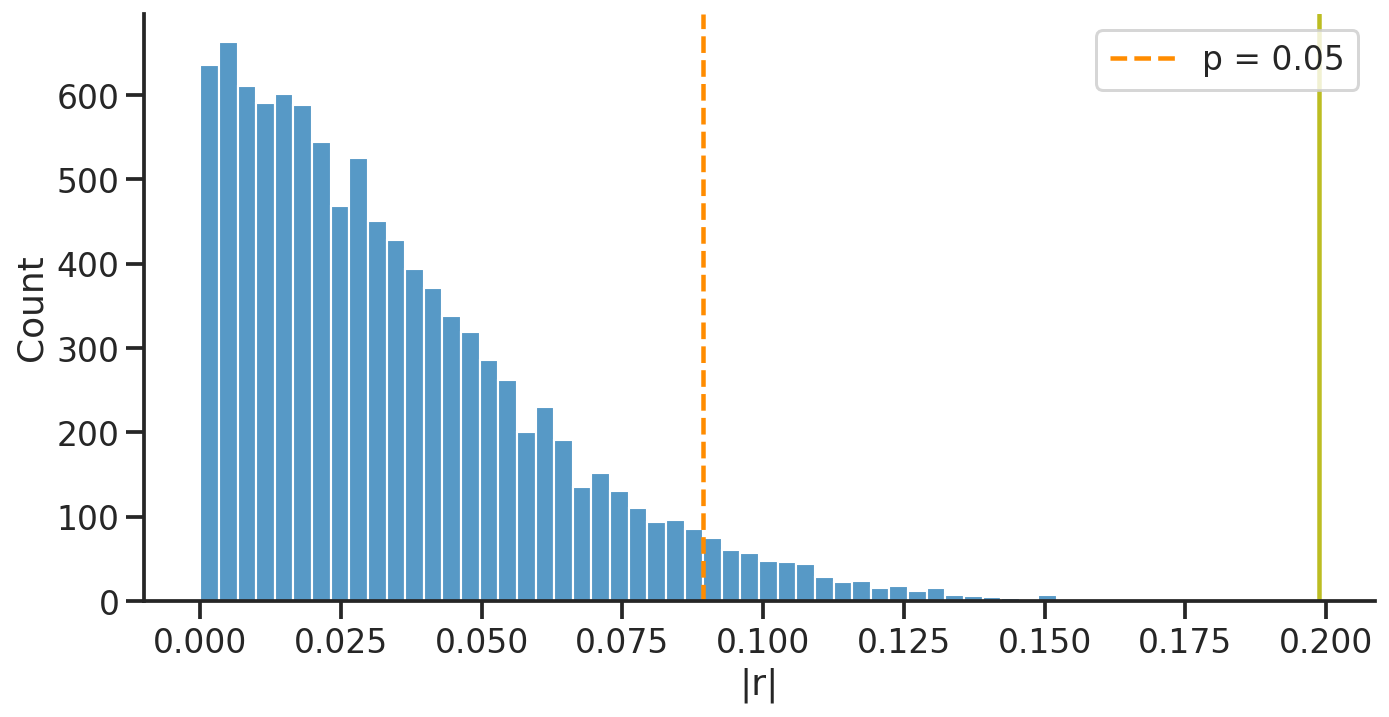

In [22]:
utils.plot_null_hist(Lag1eROIv_FCK_vs_FC_zED.stat_obs, Lag1eROIv_FCK_vs_FC_zED.stat_null)

### e(lag|roi_vols + FC K + RE) ~ FC + ED

In [23]:
Lag1eROIv_FCK_RE_vs_FC_zED = ap.manly_corr(Lag1_vs_ROIv_FCK_RE_YData, dat_edges, 'fc_edges', 'ed')

In [24]:
Lag1eROIv_FCK_RE_vs_FC_zED.stat_obs

array([-0.11830353])

In [25]:
Lag1eROIv_FCK_RE_vs_FC_zED.p_vals

p_greater    0.9991
p_less       0.0010
p_abs        0.0014
dtype: float64

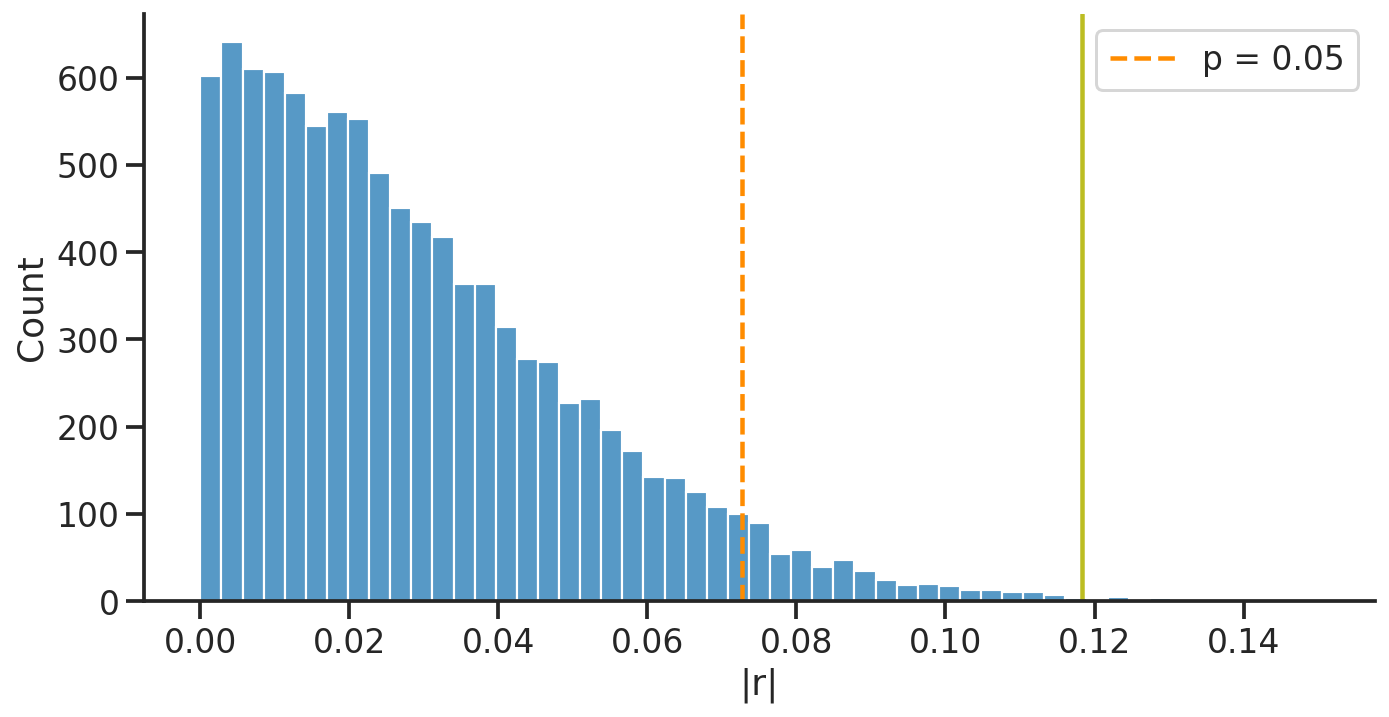

In [26]:
utils.plot_null_hist(Lag1eROIv_FCK_RE_vs_FC_zED.stat_obs, Lag1eROIv_FCK_RE_vs_FC_zED.stat_null)

# SC

### e(lag|roi_vols) ~ SC

##### Partial correlation (non-zero connections)

In [27]:
Lag1eROIv_vs_SC = ap.null_corr(Lag1_vs_ROIv_YData.y_raw, sc_mat, 10000, feat_perms=Lag1_vs_ROIv_YData.y_perms,
                               dropz=True, return_null=True, return_surrogates=False)

In [28]:
Lag1eROIv_vs_SC.r_obs

,n,r,CI95%,p-val,BF10,power
pearson,1740,-0.089548,"[-0.14, -0.04]",0.000184,32.566,0.962721


In [29]:
Lag1eROIv_vs_SC.p_vals

p_greater    0.881012
p_less       0.119088
p_abs        0.120188
dtype: float64

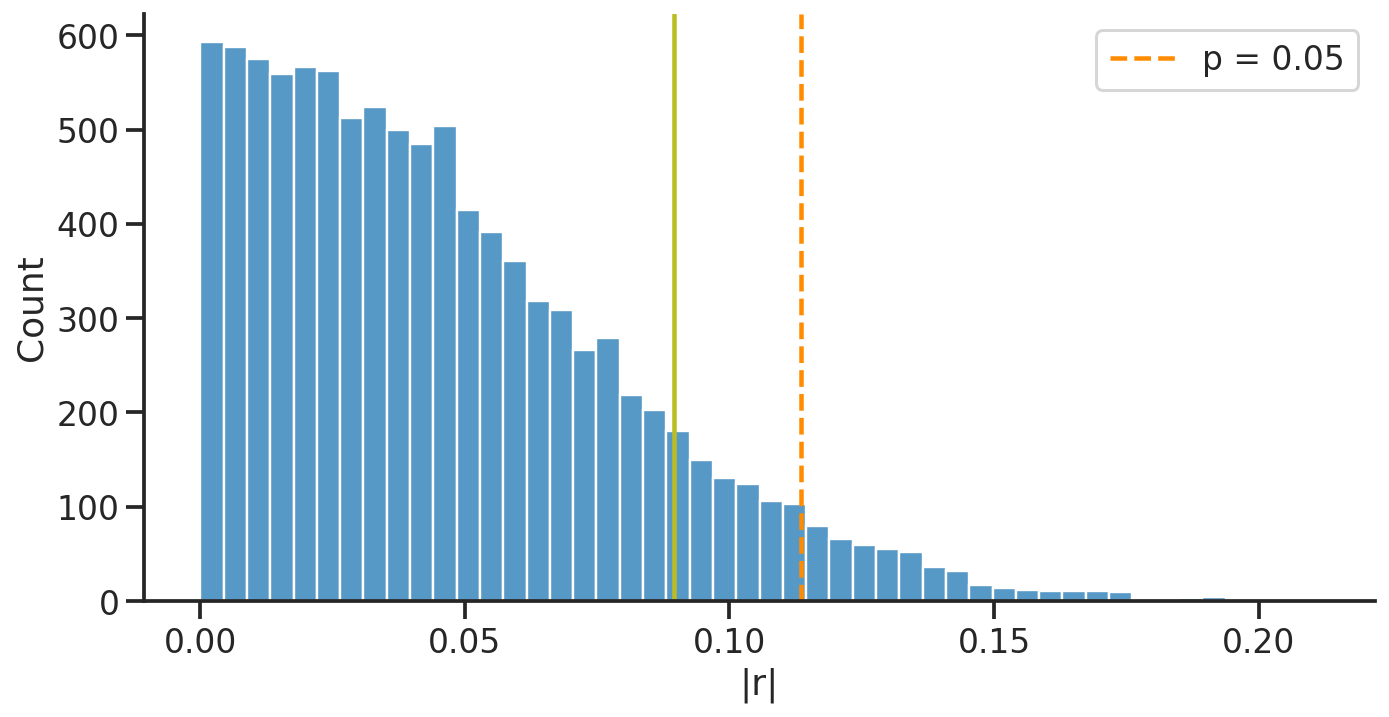

In [30]:
utils.plot_null_hist(Lag1eROIv_vs_SC.r_obs.r.pearson, Lag1eROIv_vs_SC.r_null)

### e(lag|roi_vols) ~ SC + ED

##### Partial correlation (non-zero connections)

In [31]:
Lag1eROIv_vs_SC_zED = ap.manly_corr(Lag1_vs_ROIv_YData, dat_edges, 'sc_edges', 'ed', dropz=True)

In [32]:
Lag1eROIv_vs_SC_zED.stat_obs

array([-0.0549515])

In [33]:
Lag1eROIv_vs_SC_zED.p_vals

p_greater    0.895910
p_less       0.104190
p_abs        0.175982
dtype: float64

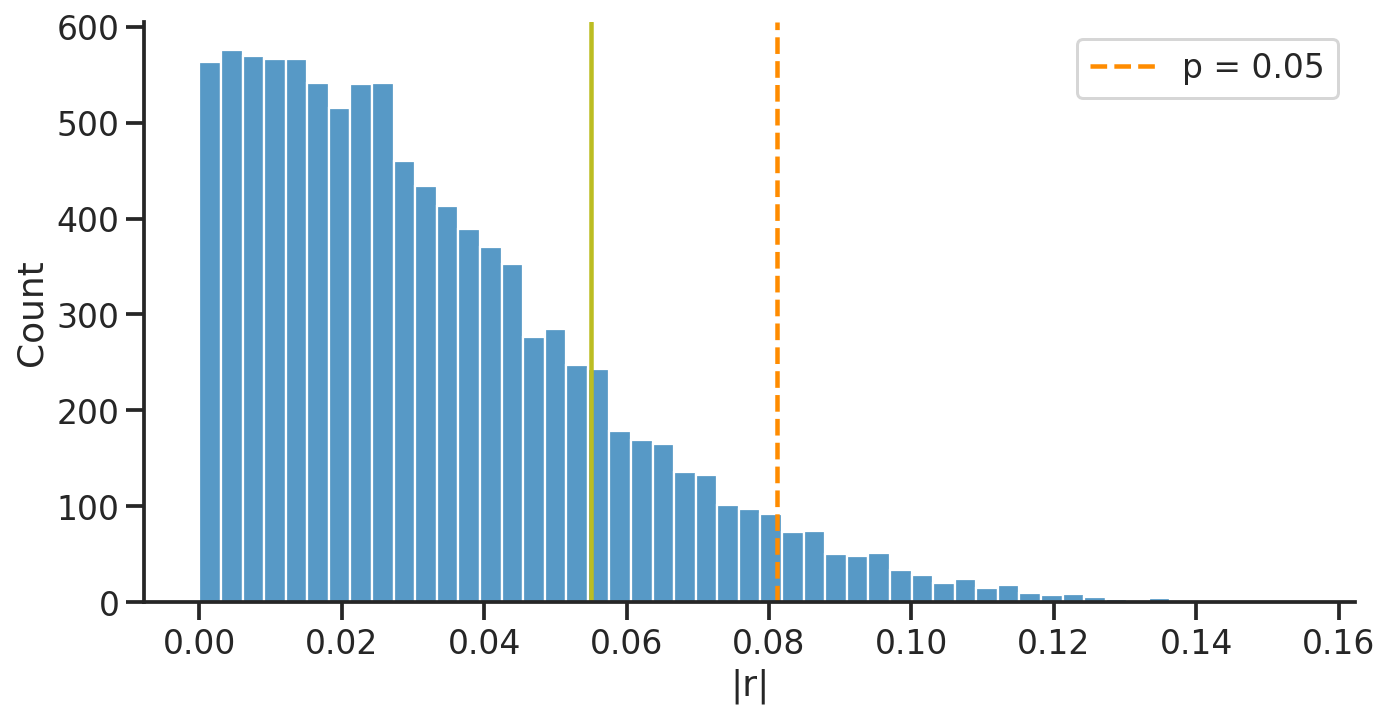

In [34]:
utils.plot_null_hist(Lag1eROIv_vs_SC_zED.stat_obs, Lag1eROIv_vs_SC_zED.stat_null)

##### T-test (connected vs. unconnected)

In [35]:
Lag1eROIv_vs_SC_zED_bin = ap.binary_connection_test(Lag1_vs_ROIv_YData.y_raw, Lag1_vs_ROIv_YData.y_perms, 
                                                dat_edges.ed.values, sc_mat, return_null=True, return_model=True)

In [36]:
Lag1eROIv_vs_SC_zED_bin.t_obs

-11.785477589264282

In [37]:
Lag1eROIv_vs_SC_zED_bin.p_vals

p_greater    0.955304
p_less       0.044796
p_abs        0.051195
dtype: float64

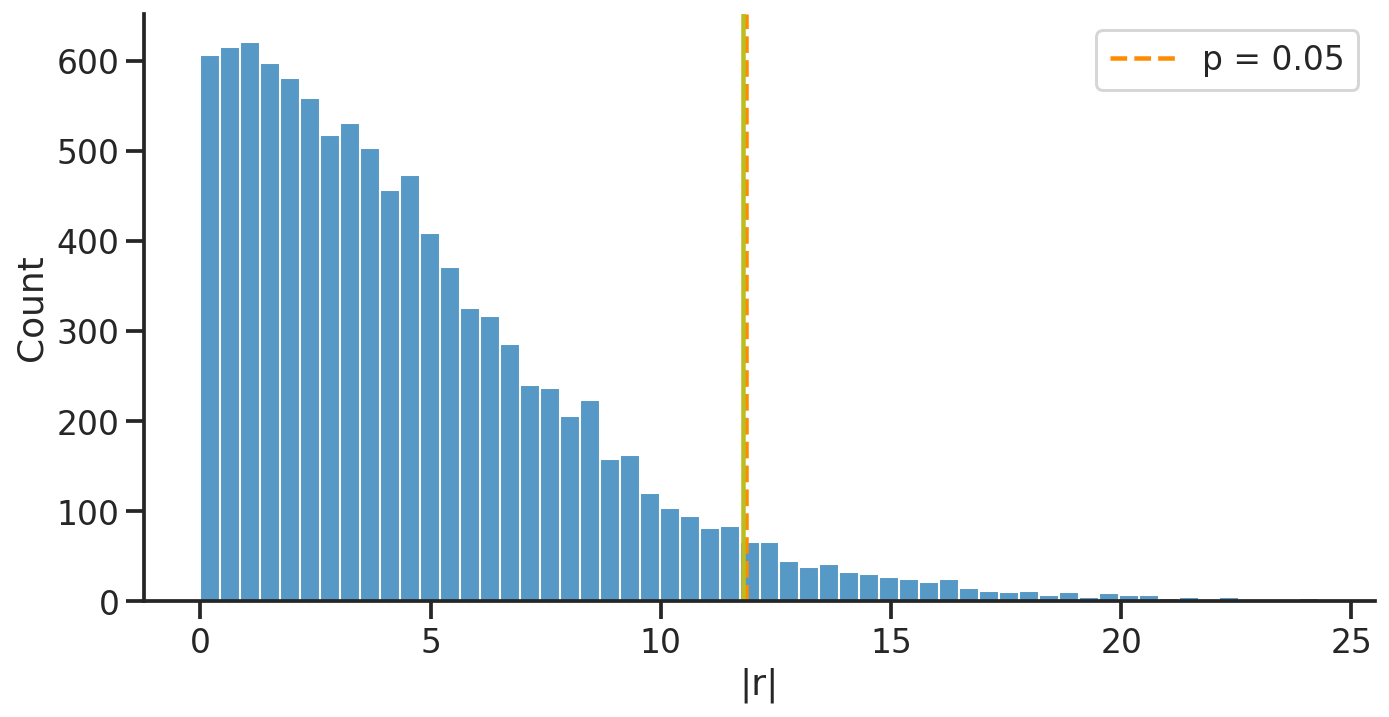

In [38]:
utils.plot_null_hist(Lag1eROIv_vs_SC_zED_bin.t_obs, Lag1eROIv_vs_SC_zED_bin.t_null)

### e(lag|roi_vols + SC K) ~ SC + ED

##### Partial correlation (non-zero connections)

In [39]:
Lag1eROIv_SCK_vs_SC_zED = ap.manly_corr(Lag1_vs_ROIv_SCK_YData, dat_edges, 'sc_edges', 'ed', dropz=True)

In [40]:
Lag1eROIv_SCK_vs_SC_zED.stat_obs

array([-0.04637269])

In [41]:
Lag1eROIv_SCK_vs_SC_zED.p_vals

p_greater    0.845515
p_less       0.154585
p_abs        0.261774
dtype: float64

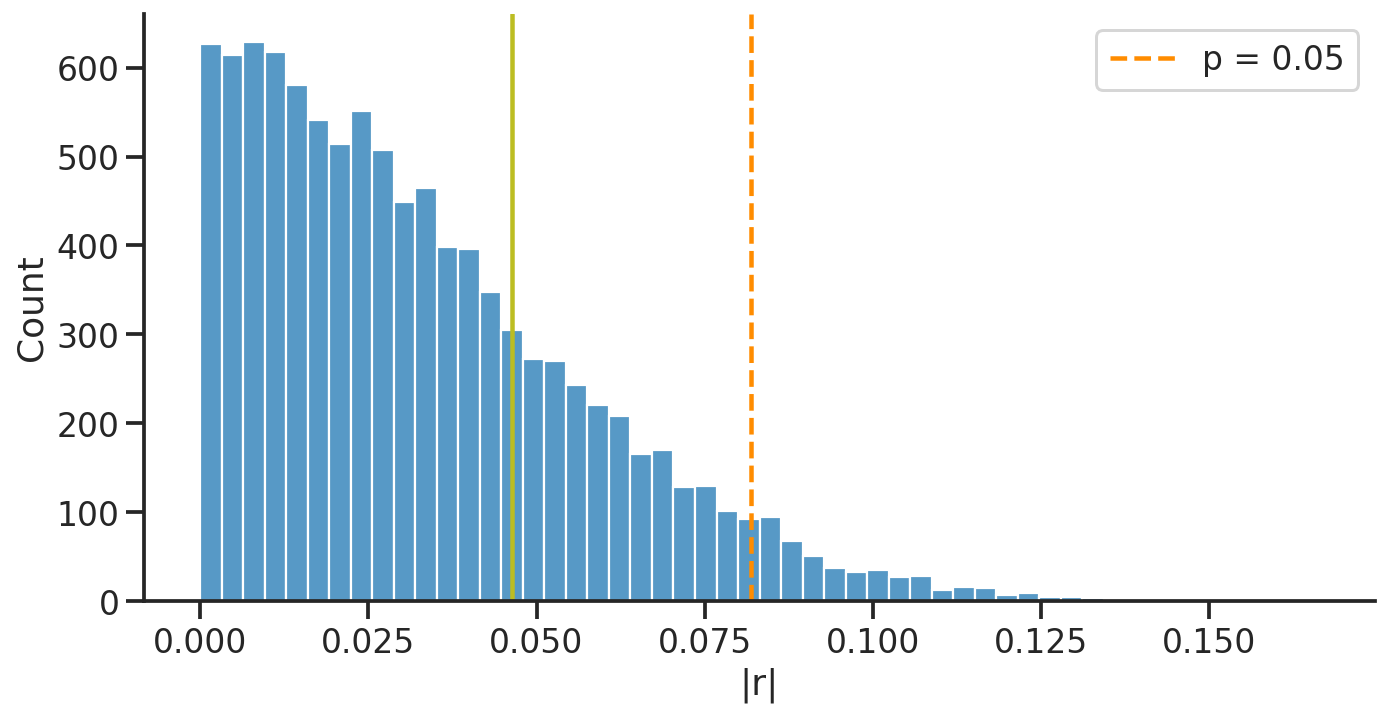

In [42]:
utils.plot_null_hist(Lag1eROIv_SCK_vs_SC_zED.stat_obs, Lag1eROIv_SCK_vs_SC_zED.stat_null)

##### T-test (connected vs. unconnected)

In [43]:
Lag1eROIv_SCK_vs_SC_zED_bin = ap.binary_connection_test(Lag1_vs_ROIv_SCK_YData.y_raw, Lag1_vs_ROIv_SCK_YData.y_perms, 
                                                dat_edges.ed.values, sc_mat, return_null=True, return_model=True)

In [44]:
Lag1eROIv_SCK_vs_SC_zED_bin.t_obs

-10.325354988247

In [45]:
Lag1eROIv_SCK_vs_SC_zED_bin.p_vals

p_greater    0.922108
p_less       0.077992
p_abs        0.093191
dtype: float64

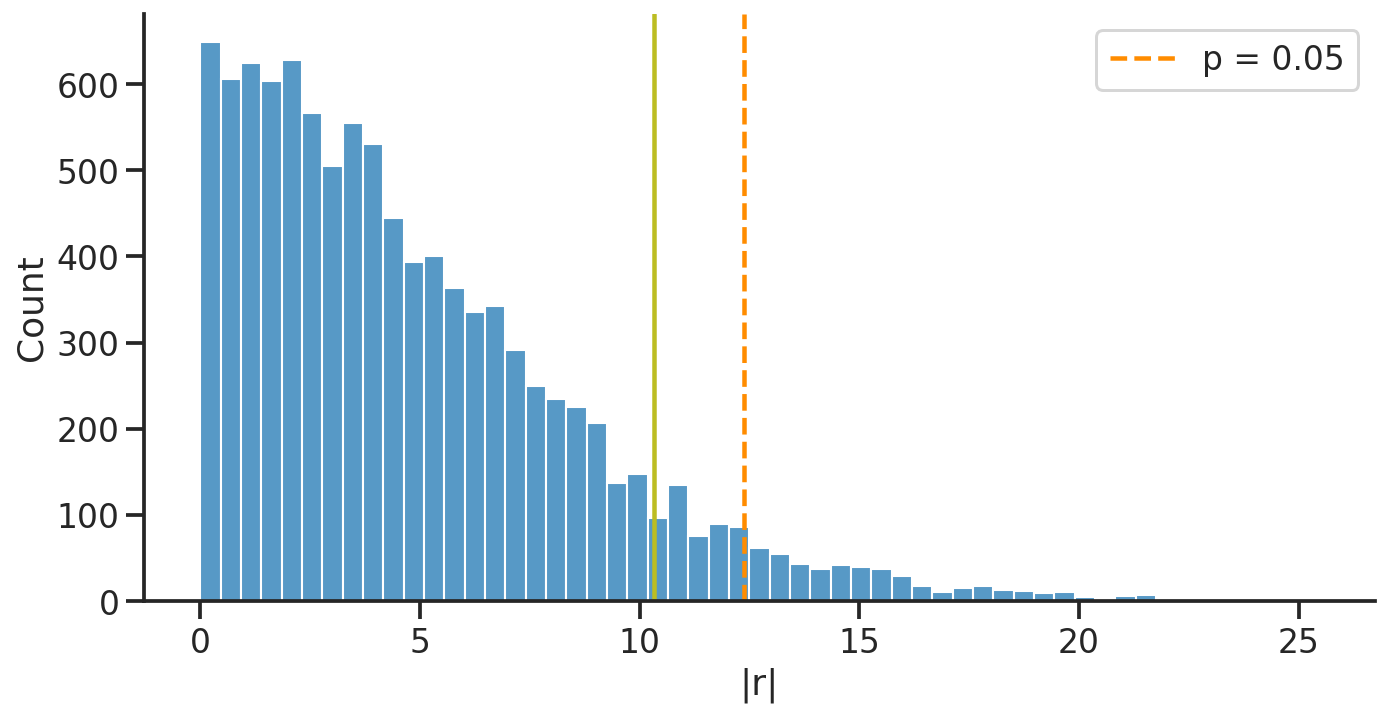

In [46]:
utils.plot_null_hist(Lag1eROIv_SCK_vs_SC_zED_bin.t_obs, Lag1eROIv_SCK_vs_SC_zED_bin.t_null)

### e(lag|roi_vols + SC K + RE) ~ SC + ED

##### Partial correlation (non-zero connections)

In [47]:
Lag1eROIv_SCK_RE_vs_SC_zED = ap.manly_corr(Lag1_vs_ROIv_SCK_RE_YData, dat_edges, 'sc_edges', 'ed', dropz=True)

In [48]:
Lag1eROIv_SCK_RE_vs_SC_zED.stat_obs

array([-0.0808136])

In [49]:
Lag1eROIv_SCK_RE_vs_SC_zED.p_vals

p_greater    0.979402
p_less       0.020698
p_abs        0.036796
dtype: float64

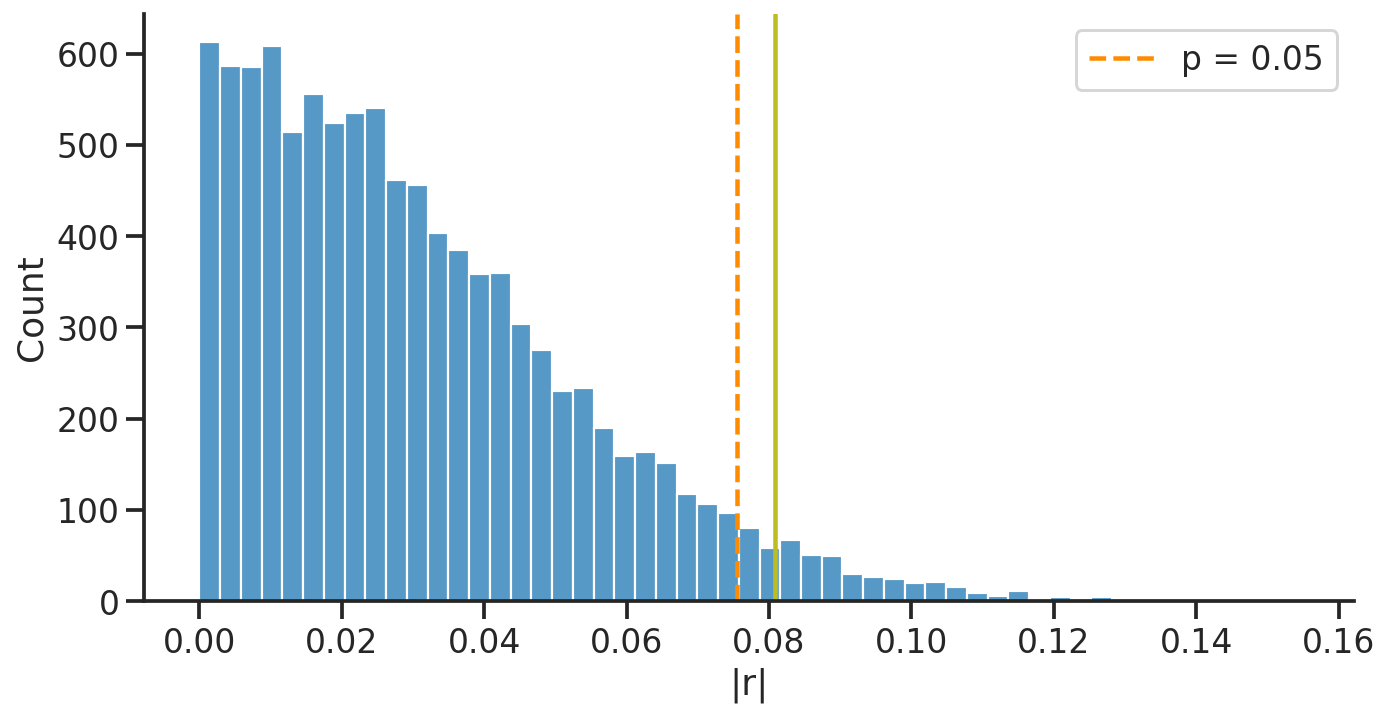

In [50]:
utils.plot_null_hist(Lag1eROIv_SCK_RE_vs_SC_zED.stat_obs, Lag1eROIv_SCK_RE_vs_SC_zED.stat_null)

##### T-test (connected vs. unconnected)

In [51]:
Lag1eROIv_SCK_RE_vs_SC_zED_bin = ap.binary_connection_test(Lag1_vs_ROIv_SCK_RE_YData.y_raw, Lag1_vs_ROIv_SCK_RE_YData.y_perms, 
                                                dat_edges.ed.values, sc_mat, return_null=True, return_model=True)

In [52]:
Lag1eROIv_SCK_RE_vs_SC_zED_bin.t_obs

-5.197843146795796

In [53]:
Lag1eROIv_SCK_RE_vs_SC_zED_bin.p_vals

p_greater    0.829617
p_less       0.170483
p_abs        0.237676
dtype: float64

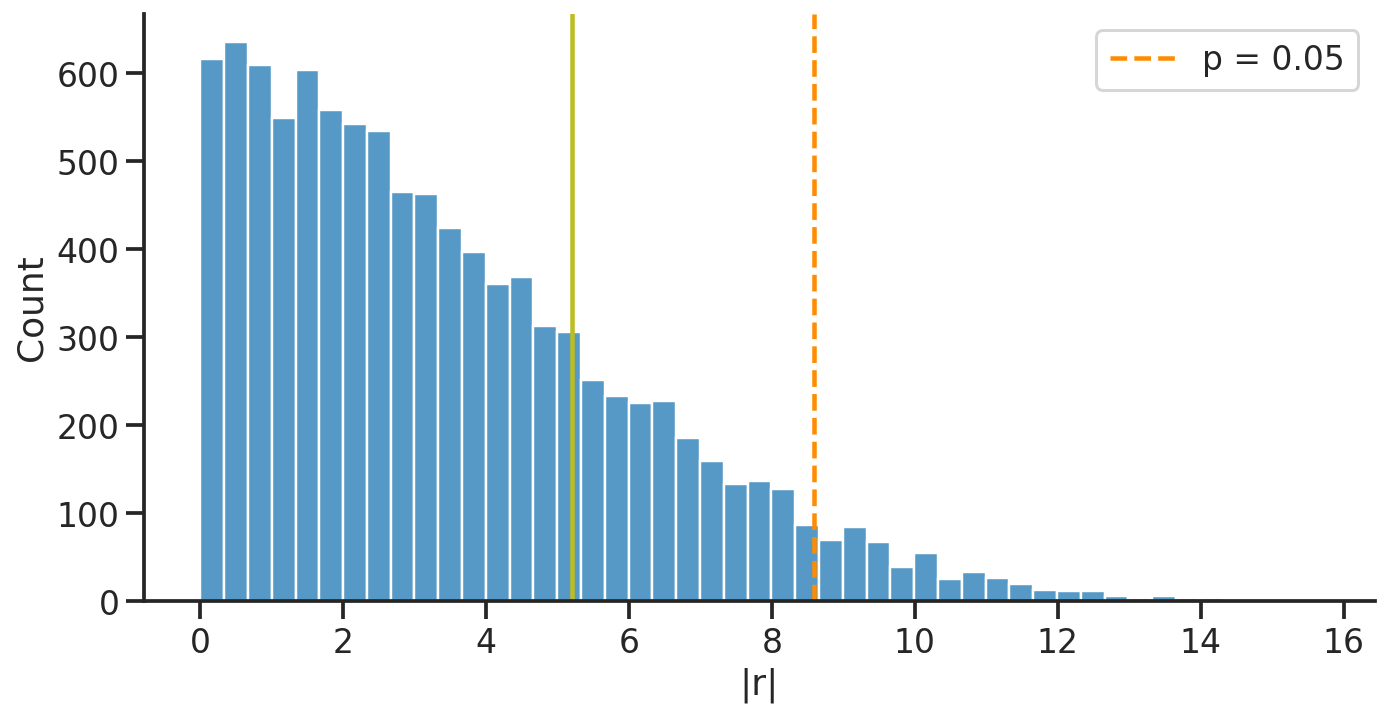

In [54]:
utils.plot_null_hist(Lag1eROIv_SCK_RE_vs_SC_zED_bin.t_obs, Lag1eROIv_SCK_RE_vs_SC_zED_bin.t_null)

## Gather results, run FDR, and save to CSV.

In [55]:
model_labels = ["Lag1eROIv_vs_FC", "Lag1eROIv_vs_FC_zED", "Lag1eROIv_FCK_vs_FC_zED", "Lag1eROIv_FCK_RE_vs_FC_zED",
                "Lag1eROIv_vs_SC", "Lag1eROIv_vs_SC_zED", "Lag1eROIv_vs_SC_zED_bin", "Lag1eROIv_SCK_vs_SC_zED", 
                "Lag1eROIv_SCK_vs_SC_zED_bin", "Lag1eROIv_SCK_RE_vs_SC_zED", "Lag1eROIv_SCK_RE_vs_SC_zED_bin"]

In [56]:
pval_array = [Lag1eROIv_vs_FC.p_vals.p_abs, Lag1eROIv_vs_FC_zED.p_vals.p_abs, Lag1eROIv_FCK_vs_FC_zED.p_vals.p_abs, 
              Lag1eROIv_FCK_RE_vs_FC_zED.p_vals.p_abs, Lag1eROIv_vs_SC.p_vals.p_abs, Lag1eROIv_vs_SC_zED.p_vals.p_abs,
              Lag1eROIv_vs_SC_zED_bin.p_vals.p_abs, Lag1eROIv_SCK_vs_SC_zED.p_vals.p_abs, Lag1eROIv_SCK_vs_SC_zED_bin.p_vals.p_abs, 
              Lag1eROIv_SCK_RE_vs_SC_zED.p_vals.p_abs, Lag1eROIv_SCK_RE_vs_SC_zED_bin.p_vals.p_abs]

In [57]:
stat_array = [Lag1eROIv_vs_FC.r_obs.r.pearson, Lag1eROIv_vs_FC_zED.stat_obs[0], Lag1eROIv_FCK_vs_FC_zED.stat_obs[0], 
              Lag1eROIv_FCK_RE_vs_FC_zED.stat_obs[0], Lag1eROIv_vs_SC.r_obs.r.pearson, Lag1eROIv_vs_SC_zED.stat_obs[0],
              Lag1eROIv_vs_SC_zED_bin.t_obs, Lag1eROIv_SCK_vs_SC_zED.stat_obs[0], Lag1eROIv_SCK_vs_SC_zED_bin.t_obs, 
              Lag1eROIv_SCK_RE_vs_SC_zED.stat_obs[0], Lag1eROIv_SCK_RE_vs_SC_zED_bin.t_obs]

In [58]:
res_df = pd.DataFrame([pval_array, stat_array], columns=model_labels, index=['pval','stat']).T

In [59]:
res_df['qval'] = sm.stats.multipletests(res_df.pval.values, alpha=0.05, method='fdr_bh')[1]

In [60]:
out_dir = os.path.join(results_dir, 'stats','connectivity_preference')
if os.path.isdir(out_dir) is False:
    os.makedirs(out_dir)

out_path = os.path.join(out_dir, f'{fmri_data_label}_{dwi_data_label}_BNA_{roi_subset}_GlobalConnPref_resDF.csv')
res_df.to_csv(out_path)
os.chmod(out_path, S_IREAD|S_IRGRP|S_IROTH) # Make results read-only